## Unrolled generative adversarial network demo
- double check architecture/hyperparams\
- note differences from paper
- set random seed?
- add more comments

In [1]:
%pylab inline
from collections import OrderedDict
import tensorflow as tf
ds = tf.contrib.distributions
slim = tf.contrib.slim
graph_replace = tf.contrib.graph_editor.graph_replace

from keras.optimizers import Adam

try:
    from moviepy.video.io.bindings import mplfig_to_npimage
    import moviepy.editor as mpy
    generate_movie = True
except:
    print("Warning: moviepy not found.")
    generate_movie = False

Using TensorFlow backend.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '



Populating the interactive namespace from numpy and matplotlib


### Utility functions

In [2]:
def extract_update_dict(update_ops):
    """Extract variables and their new values from Assign and AssignAdd ops.
    
    Args:
        update_ops: list of Assign and AssignAdd ops, typically computed using Keras' opt.get_updates()

    Returns:
        dict mapping from variable values to their updated value
    """
    name_to_var = {v.name: v for v in tf.global_variables()}
    updates = OrderedDict()
    for update in update_ops:
        var_name = update.op.inputs[0].name
        var = name_to_var[var_name]
        value = update.op.inputs[1]
        if update.op.type == 'Assign':
            updates[var.value()] = value
        elif update.op.type == 'AssignAdd':
            updates[var.value()] = var + value
        else:
            raise ValueError("Update op type (%s) must be of type Assign or AssignAdd"%update_op.op.type)
    return updates

### Data creation

In [3]:
def sample_mog(batch_size, n_mixture=8, std=0.01):
    thetas = np.linspace(0, 2 * np.pi, n_mixture)
    xs, ys = np.sin(thetas), np.cos(thetas)
    cat = ds.Categorical(tf.zeros(n_mixture))
    comps = [ds.MultivariateNormalDiag([xi, yi], [std, std]) for xi, yi in zip(xs.ravel(), ys.ravel())]
    data = ds.Mixture(cat, comps)
    return data.sample_n(batch_size)

### Generator and discriminator architectures

In [9]:
def generator(z, output_dim=2, n_hidden=128, n_layer=2):
    with tf.variable_scope("generator"):
        h = slim.stack(z, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.tanh)
        x = slim.fully_connected(h, output_dim, activation_fn=None)
    return x

def discriminator(x, n_hidden=128, n_layer=2, reuse=False):
    with tf.variable_scope("discriminator", reuse=reuse):
        h = slim.stack(x, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.tanh)
        log_d = slim.fully_connected(h, 1, activation_fn=None)
    return log_d

### Hyperparameters

In [10]:
params = dict(
    batch_size=512,
    disc_learning_rate=1e-4,
    gen_learning_rate=1e-3,
    beta1=0.5,
    epsilon=1e-8,
    max_iter=50000,
    z_dim=256,
    x_dim=2,
    unrolling_steps=5,
)

## Construct models and training ops

In [11]:
tf.reset_default_graph()
noise = ds.Normal(tf.zeros(params['z_dim']), 
                  tf.ones(params['z_dim'])).sample_n(params['batch_size'])
with slim.arg_scope([slim.fully_connected], weights_initializer=tf.orthogonal_initializer(gain=1.4)):
    samples = generator(noise, output_dim=params['x_dim'])
    data = sample_mog(params['batch_size'])

    real_score = discriminator(data)
    fake_score = discriminator(samples, reuse=True)
    
loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(real_score, tf.ones_like(real_score)) +
    tf.nn.sigmoid_cross_entropy_with_logits(fake_score, tf.zeros_like(fake_score)))

gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")

# Vanilla discriminator update
d_opt = Adam(lr=params['disc_learning_rate'], beta_1=params['beta1'], epsilon=params['epsilon'])
updates = d_opt.get_updates(disc_vars, [], loss)
d_train_op = tf.group(*updates, name="d_train_op")

# Unroll optimization of the discrimiantor
if params['unrolling_steps'] > 0:
    # Get dictionary mapping from variables to their update value after one optimization step
    update_dict = extract_update_dict(updates)
    cur_update_dict = update_dict
    for i in xrange(params['unrolling_steps'] - 1):
        # Compute variable updates given the previous iteration's updated variable
        cur_update_dict = graph_replace(update_dict, cur_update_dict)
    # Final unrolled loss uses the parameters at the last time step
    unrolled_loss = graph_replace(loss, cur_update_dict)
else:
    unrolled_loss = loss

# Optimize the generator on the unrolled loss
g_train_opt = tf.train.AdamOptimizer(params['gen_learning_rate'], beta1=params['beta1'], epsilon=params['epsilon'])
g_train_op = g_train_opt.minimize(-unrolled_loss, var_list=gen_vars)

  warnings.warn('The default TensorFlow graph is not the graph '



## Train!

In [ ]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

  0%|          | 0/50000 [00:00<?, ?it/s]

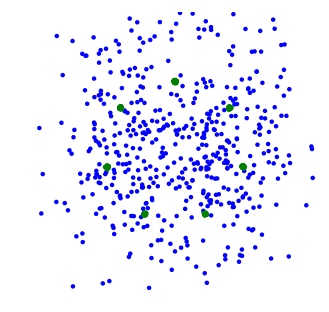

  1%|          | 498/50000 [00:18<30:28, 27.07it/s]

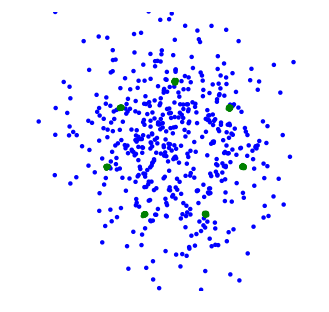

  2%|▏         | 997/50000 [00:36<27:41, 29.50it/s]

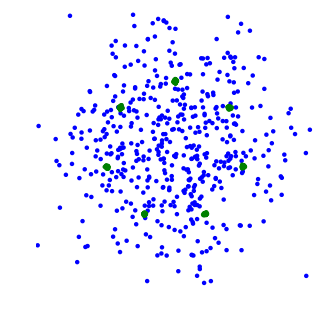

  3%|▎         | 1499/50000 [00:55<28:04, 28.78it/s]

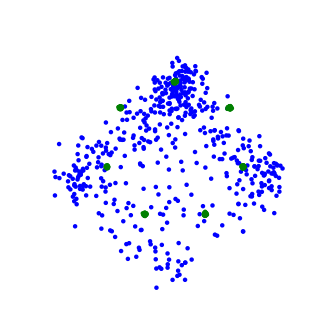

  4%|▍         | 1999/50000 [01:12<28:14, 28.34it/s]

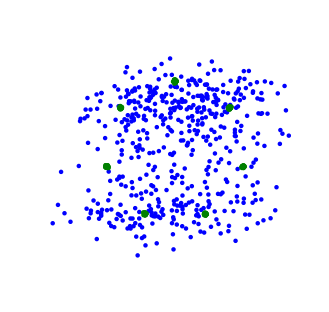

  5%|▍         | 2498/50000 [01:31<26:03, 30.38it/s]

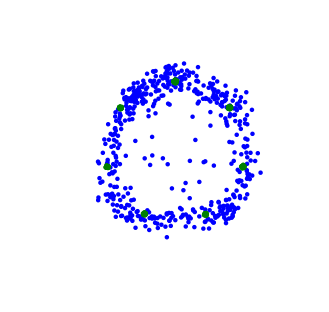

  6%|▌         | 2998/50000 [01:49<25:52, 30.28it/s]

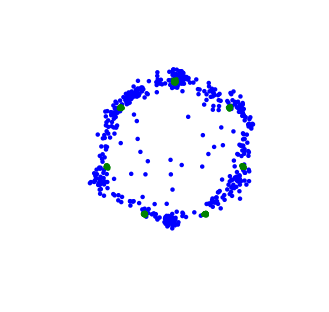

  7%|▋         | 3499/50000 [02:07<25:58, 29.83it/s]

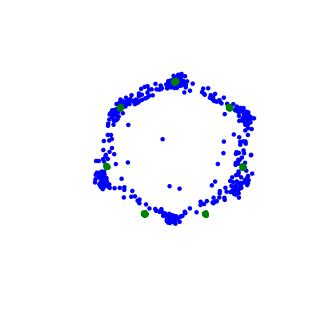

  8%|▊         | 3997/50000 [02:25<26:15, 29.20it/s]

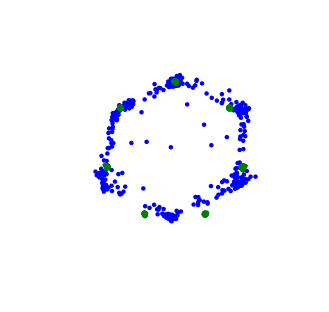

  9%|▉         | 4498/50000 [02:43<25:13, 30.06it/s]

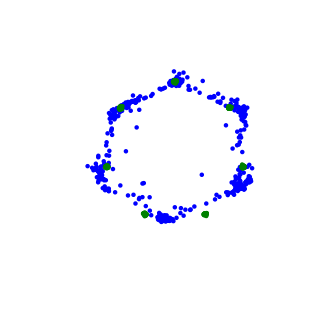

 10%|▉         | 4999/50000 [03:01<24:59, 30.01it/s]

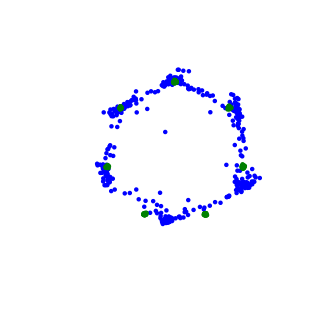

 11%|█         | 5499/50000 [03:18<23:07, 32.08it/s]

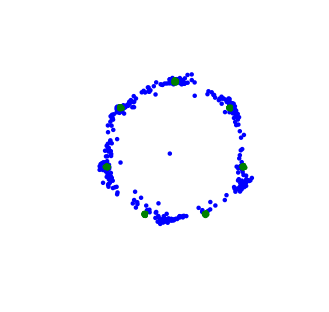

 12%|█▏        | 5997/50000 [03:34<22:30, 32.59it/s]

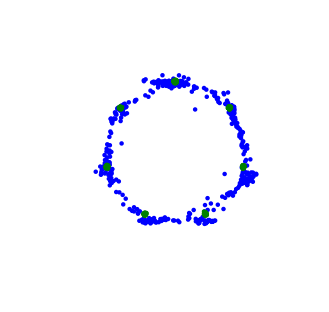

 13%|█▎        | 6499/50000 [03:51<22:14, 32.61it/s]

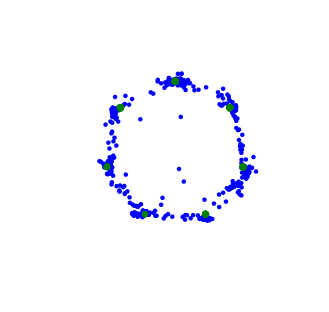

 14%|█▍        | 7000/50000 [04:08<23:34, 30.39it/s]

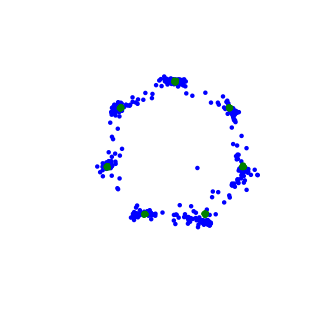

 15%|█▍        | 7499/50000 [04:26<22:37, 31.31it/s]

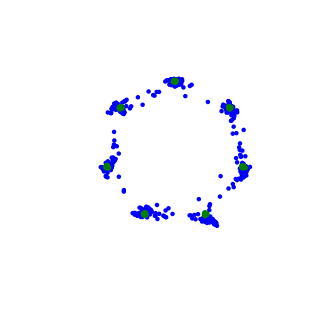

 16%|█▌        | 7998/50000 [04:44<23:10, 30.20it/s]

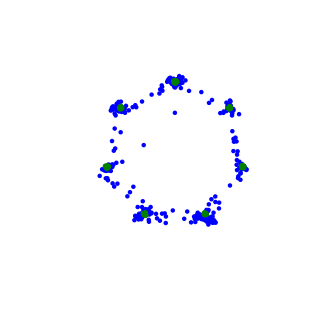

 17%|█▋        | 8497/50000 [05:01<23:13, 29.79it/s]

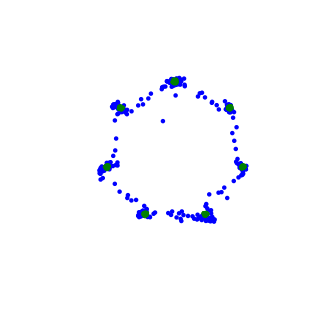

 18%|█▊        | 8998/50000 [05:19<23:03, 29.64it/s]

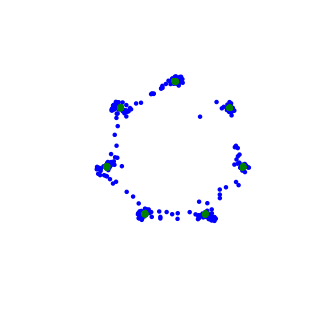

 19%|█▉        | 9498/50000 [05:37<22:05, 30.55it/s]

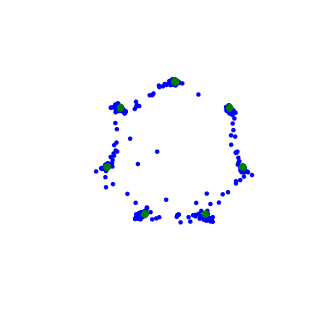

 20%|█▉        | 9997/50000 [05:55<21:32, 30.95it/s]

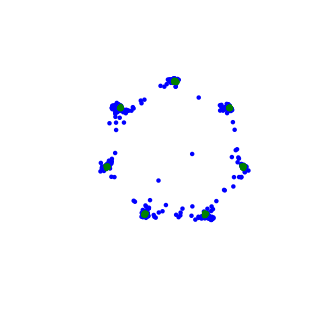

 21%|██        | 10497/50000 [06:12<22:15, 29.57it/s]

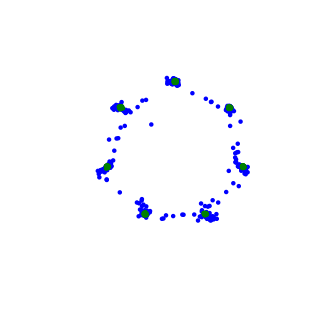

 22%|██▏       | 10998/50000 [06:30<21:17, 30.54it/s]

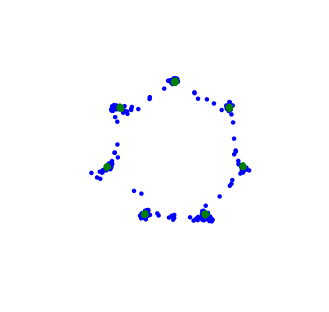

 23%|██▎       | 11500/50000 [06:48<21:51, 29.36it/s]

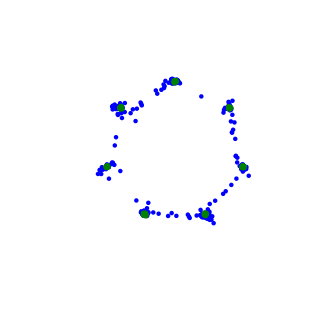

 24%|██▍       | 12000/50000 [07:06<20:36, 30.73it/s]

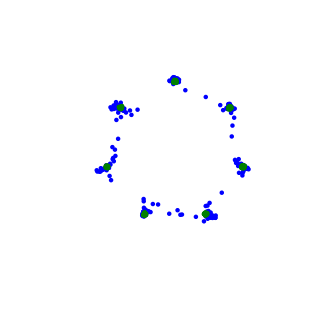

 25%|██▍       | 12498/50000 [07:24<20:52, 29.95it/s]

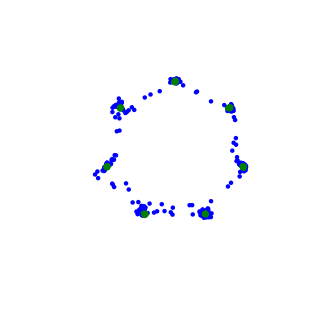

 26%|██▌       | 12999/50000 [07:41<20:02, 30.76it/s]

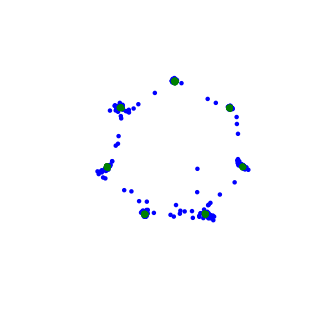

 27%|██▋       | 13497/50000 [07:59<20:36, 29.53it/s]

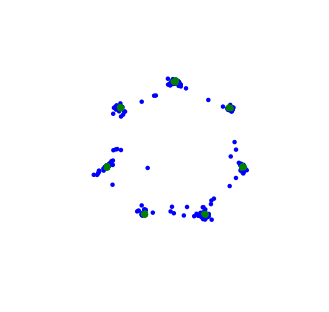

 28%|██▊       | 13999/50000 [08:17<20:09, 29.77it/s]

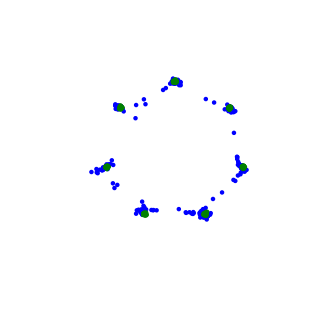

 29%|██▉       | 14423/50000 [08:32<19:52, 29.83it/s]

In [ ]:
from tqdm import tqdm
fs = []
frames = []
fig = figure(figsize=(5,5))
for i in tqdm(xrange(params['max_iter'])):
    f, _, _ = sess.run([[loss, unrolled_loss], g_train_op, d_train_op])
    fs.append(f)
    if i % 25 == 0:
        xx, yy = sess.run([samples, data])
        clf()
        scatter(xx[:, 0], xx[:, 1], edgecolor='none')
        scatter(yy[:, 0], yy[:, 1], c='g', edgecolor='none')
        xlim(-2, 2)
        ylim(-2, 2)
        axis('off')
        draw()
        if generate_movie:
            frames.append(mplfig_to_npimage(fig))
        if i % 500 == 0:
            show()
            fig = figure(figsize=(5,5))

In [ ]:
np_loss, np_unrolled = np.array(fs).T
plot(np_loss-np_unrolled)

In [ ]:
clip = mpy.ImageSequenceClip(frames[::], fps=30)
clip.ipython_display()

In [ ]:
semilogy(fs)
legend(('loss', 'unrolled loss'))